In [1]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [8]:
data = pd.read_csv("Data/blinded_patient_data_with_adjusted_noise.csv")
data.head()

,Patient ID,Age,Sex,Symptoms,Search Query,Rater,Official_DX,Rater_DX,Rater_DX_Clean,ChatGPT_Guess_1,ChatGPT_Guess_2,ChatGPT_Guess_3,ChatGPT_Clean_1,ChatGPT_Clean_2,ChatGPT_Clean_3,ChatGPT_Mode_Filter1,ChatGPT_Mode
0,1,35,Female,"['Sneezing', 'Runny Nose', 'Itchy Eyes', 'Mild...","I am feeling Sneezing, Runny Nose, Itchy Eyes,...",Yiwei,Cold,Allergic Rhinitis,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies
1,2,20,Male,"['Sneezing', 'Runny Nose', 'Itchy Eyes', 'Shor...","Why am I experiencing Sneezing, Runny Nose, It...",Josue,Allergies,Allergie,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies,Allergies
2,3,31,Male,"['Depressed Mood', 'Loss of Interest', 'Fatigu...","What does it mean if I have Depressed Mood, Lo...",Olivia,Depression,Depression,Depression,Major depressive disorder,Major depressive disorder,Major depressive disorder,Depression,Depression,Depression,Depression,Depression
3,4,61,Male,"['Chest Pain', 'Shortness of Breath', 'Fatigue...","Why am I experiencing Chest Pain, Shortness of...",Matias,Heart Disease,Heart Failure,Heart Failure,Congestive heart failure,Congestive heart failure,Congestive heart failure.,Congestive Heart Failure,Congestive Heart Failure,Congestive Heart Failure,Congestive Heart Failure,Congestive Heart Failure
4,5,34,Female,"['Depressed Mood', 'Loss of Interest', 'Fatigu...","Why am I experiencing Depressed Mood, Loss of ...",Jane,Depression,Depression,Depression,Major depressive disorder,Major depressive disorder,Major depressive disorder,Depression,Depression,Depression,Depression,Depression


In [11]:
subset = data[['Official_DX', 'Rater_DX_Clean', 'ChatGPT_Clean_1', 'ChatGPT_Clean_2', 'ChatGPT_Clean_3']]

In [12]:
subset

,Official_DX,Rater_DX_Clean,ChatGPT_Clean_1,ChatGPT_Clean_2,ChatGPT_Clean_3
0,Cold,Allergies,Allergies,Allergies,Allergies
1,Allergies,Allergies,Allergies,Allergies,Allergies
2,Depression,Depression,Depression,Depression,Depression
3,Heart Disease,Heart Failure,Congestive Heart Failure,Congestive Heart Failure,Congestive Heart Failure
4,Depression,Depression,Depression,Depression,Depression
...,...,...,...,...,...
295,Flu,Flu,Common Cold,Common Cold,Common Cold
296,Cold,Allergies,Allergies,Allergies,Allergies
297,Flu,Flu,Flu,Flu,Flu
298,Depression,Depression,Depression,Depression,Depression


In [13]:
subset.to_csv("Data/subset.csv")

### Cleaning

In [14]:
# Preprocessing: Convert all text to lower case, remove punctuation, strip white spaces
def preprocess_text(text):
    # Make text lower case
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Strip white spaces
    text = text.strip()

    return text

In [15]:
# Apply preprocessing to all text columns
for col in subset.columns:
    subset.loc[:, col] = subset[col].apply(preprocess_text)

/Users/carlybobak/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


### Vector Embeddings to  all diseases

In [16]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_lg')

In [26]:
# create vector embeddings and store as a df
#official_vector = pd.DataFrame(subset['Official_DX'].apply(lambda x: nlp(x).vector).tolist())
#official_vector.head()

# Get all unique strings from all columns
unique_values = pd.unique(subset.select_dtypes(include=[object]).values.ravel('K'))

# Convert the array of unique values to a DataFrame
unique_values_df = pd.DataFrame(unique_values, columns=['Unique_Strings'])
print(unique_values_df)

official_vector = unique_values_df['Unique_Strings'].apply(lambda x: nlp(x).vector).tolist()
print(official_vector)



              Unique_Strings
0                       cold
1                  allergies
2                 depression
3              heart disease
4               hypertension
5           anxiety disorder
6                   diabetes
7                        flu
8                     asthma
9                  arthritis
10             breast cancer
11                       ibd
12           prostate cancer
13             heart failure
14              fibromyalgia
15  congestive heart failure
16                arrhythmia
17                    anemia
18               common cold
19      neuroendocrine tumor
20           pulmonary edema
21                  migraine
22           gastroenteritis
23           prostate issues
24          high blood sugar
25               myocarditis
26         polycythemia vera
27              hypoglycemia
28                 epistaxis
29          cluster headache
30                 menopause
31              appendicitis
[array([-2.0380e-01, -1.7333e+00, -3.4671e+

### PCA 

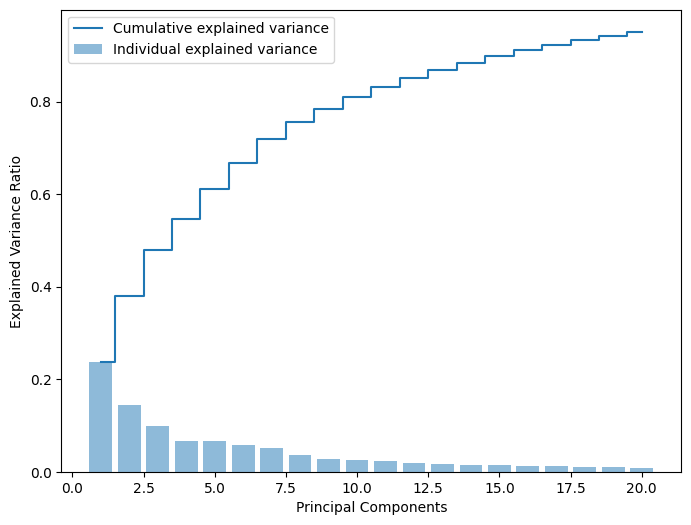

In [27]:
# Perform PCA with n_components=20
pca = PCA(n_components=20)
pca.fit(official_vector)

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot the variance explained
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, where='mid',
         label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.show()

In [28]:
pca = PCA(n_components=3)
official_pca = pd.DataFrame(pca.fit_transform(official_vector))

In [31]:
# Create a DataFrame associating each unique string with its vector
vectors = unique_values_df['Unique_Strings'].apply(lambda x: nlp(x).vector).tolist()
vector_df = pd.DataFrame(vectors)
vector_df['Unique_Strings'] = unique_values_df['Unique_Strings']

# Do PCA on the vectors
pca = PCA(n_components=3)
pca_results = pd.DataFrame(pca.fit_transform(vector_df.drop('Unique_Strings', axis=1)))

# Add the unique strings back to the PCA results
official_pca = pd.concat([pca_results, vector_df['Unique_Strings']], axis=1)

# Rename the columns
official_pca.columns = ["PC1", "PC2", "PC3", "Disease"]

### KMeans

In [32]:
from sklearn.cluster import KMeans

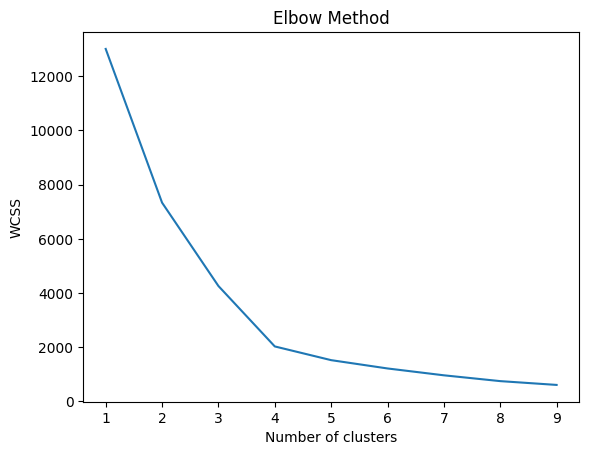

In [33]:
# List to hold the WCSS for each number of clusters
wcss = []

# Test 1-5 clusters
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(official_pca[['PC1', 'PC2', 'PC3']])
    wcss.append(kmeans.inertia_)

# Plot the results
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
# use 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(official_pca[['PC1', 'PC2', 'PC3']])

class_labels = kmeans.labels_

In [38]:
# add in class
official_pca['Class'] = class_labels
official_pca
official_pca.to_csv(f"Data/pca_embeddings.csv")

In [36]:
for i in range(4):
    tempDf = official_pca[official_pca.Class == i]
    tempDf.to_csv(f"Data/Cluster_{i}.csv")

### Create Vector Embeddings for each Cluster 

In [95]:
cluster0 = pd.read_csv("Data/Cluster_0.csv", index_col=0)
cluster0_id = cluster0.index.tolist()

cluster1 = pd.read_csv("Data/Cluster_1.csv", index_col=0)
cluster1_id = cluster1.index.tolist()

cluster2 = pd.read_csv("Data/Cluster_2.csv", index_col=0)
cluster2_id = cluster2.index.tolist()

cluster3 = pd.read_csv("Data/Cluster_3.csv", index_col=0)
cluster3_id = cluster3.index.tolist()

In [96]:
# get final cluster dfs
cluster0 = subset[subset.index.isin(cluster0_id)]
cluster1 = subset[subset.index.isin(cluster1_id)]
cluster2 = subset[subset.index.isin(cluster2_id)]
cluster3 = subset[subset.index.isin(cluster3_id)]

#### Reduce to 2D

In [83]:
## Cluster 0

# initialize empty df to store reduced (2D) vectors
cluster0_emb = pd.DataFrame(columns=["D1", "D2", "Label", "Diagnosis"])

for col in cluster0.columns.tolist():
    # get all embeddings (300D)
    tempAllEmbedding = pd.DataFrame(cluster0[col].apply(lambda x: nlp(x).vector).tolist())
    # apply PCA
    pca = PCA(n_components=2)
    tempReducedEmbedding = pd.DataFrame(pca.fit_transform(tempAllEmbedding), columns=['D1', 'D2'])
    # add label to tempdf
    tempReducedEmbedding['Label'] = [col] * cluster0.shape[0]
    # add diagnosis
    tempReducedEmbedding['Diagnosis'] = cluster0[col].tolist()

    # concate with main df
    cluster0_emb = pd.concat([cluster0_emb, tempReducedEmbedding], ignore_index = True)

In [85]:
## Cluster 1

# initialize empty df to store reduced (2D) vectors
cluster1_emb = pd.DataFrame(columns=["D1", "D2", "Label", "Diagnosis"])

for col in cluster1.columns.tolist():
    # get all embeddings (300D)
    tempAllEmbedding = pd.DataFrame(cluster1[col].apply(lambda x: nlp(x).vector).tolist())
    # apply PCA
    pca = PCA(n_components=2)
    tempReducedEmbedding = pd.DataFrame(pca.fit_transform(tempAllEmbedding), columns=['D1', 'D2'])
    # add label to tempdf
    tempReducedEmbedding['Label'] = [col] * cluster1.shape[0]
    # add diagnosis
    tempReducedEmbedding['Diagnosis'] = cluster1[col].tolist()

    # concate with main df
    cluster1_emb = pd.concat([cluster1_emb, tempReducedEmbedding], ignore_index = True)

In [86]:
## Cluster 2

# initialize empty df to store reduced (2D) vectors
cluster2_emb = pd.DataFrame(columns=["D1", "D2", "Label", "Diagnosis"])

for col in cluster2.columns.tolist():
    # get all embeddings (300D)
    tempAllEmbedding = pd.DataFrame(cluster2[col].apply(lambda x: nlp(x).vector).tolist())
    # apply PCA
    pca = PCA(n_components=2)
    tempReducedEmbedding = pd.DataFrame(pca.fit_transform(tempAllEmbedding), columns=['D1', 'D2'])
    # add label to tempdf
    tempReducedEmbedding['Label'] = [col] * cluster2.shape[0]
    # add diagnosis
    tempReducedEmbedding['Diagnosis'] = cluster2[col].tolist()

    # concate with main df
    cluster2_emb = pd.concat([cluster2_emb, tempReducedEmbedding], ignore_index = True)

In [87]:
## Cluster 3

# initialize empty df to store reduced (2D) vectors
cluster3_emb = pd.DataFrame(columns=["D1", "D2", "Label", "Diagnosis"])

for col in cluster3.columns.tolist():
    # get all embeddings (300D)
    tempAllEmbedding = pd.DataFrame(cluster3[col].apply(lambda x: nlp(x).vector).tolist())
    # apply PCA
    pca = PCA(n_components=2)
    tempReducedEmbedding = pd.DataFrame(pca.fit_transform(tempAllEmbedding), columns=['D1', 'D2'])
    # add label to tempdf
    tempReducedEmbedding['Label'] = [col] * cluster3.shape[0]
    # add diagnosis
    tempReducedEmbedding['Diagnosis'] = cluster3[col].tolist()

    # concate with main df
    cluster3_emb = pd.concat([cluster3_emb, tempReducedEmbedding], ignore_index = True)

In [88]:
# save them to local
cluster0_emb.to_csv("Data/Cluster_0_emb.csv")
cluster1_emb.to_csv("Data/Cluster_1_emb.csv")
cluster2_emb.to_csv("Data/Cluster_2_emb.csv")
cluster3_emb.to_csv("Data/Cluster_3_emb.csv")